<a href="https://colab.research.google.com/github/RyanPiao/ECON5200-Applied-Data-Analytics-in-Economics/blob/main/Lab%202/%20Lab2_Deflating_History_with_FRED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the FRED API wrapper
!pip install fredapi

In [ ]:
# Import standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred

# Authenticate
# Replace the string below with YOUR unique API key from fred.stlouisfed.org
fred = Fred(api_key='40e550be9a630ac72712f1b8d713d3c4')

In [ ]:
# Fetch Data: Wage Data and CPI Data
# AHETPI: Average Hourly Earnings of Production and Nonsupervisory Employees
# CPIAUCSL: Consumer Price Index for All Urban Consumers
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# Combine into a single DataFrame
# Note: FRED returns Series with Datetime Index, so they align automatically
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# Drop NaN values (dates where datasets don't overlap)
# AHETPI starts in 1964; CPI starts much earlier. We align to the shorter series.
df = df.dropna()

# Inspect the data
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-06-01         31.26  321.500
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031


In [ ]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]

    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today

    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-06-01         31.26  321.500  31.603325
2025-07-01         31.35  322.132  31.632132
2025-08-01         31.45  323.364  31.612130
2025-09-01         31.52  324.368  31.584426
2025-11-01         31.73  325.031  31.730000


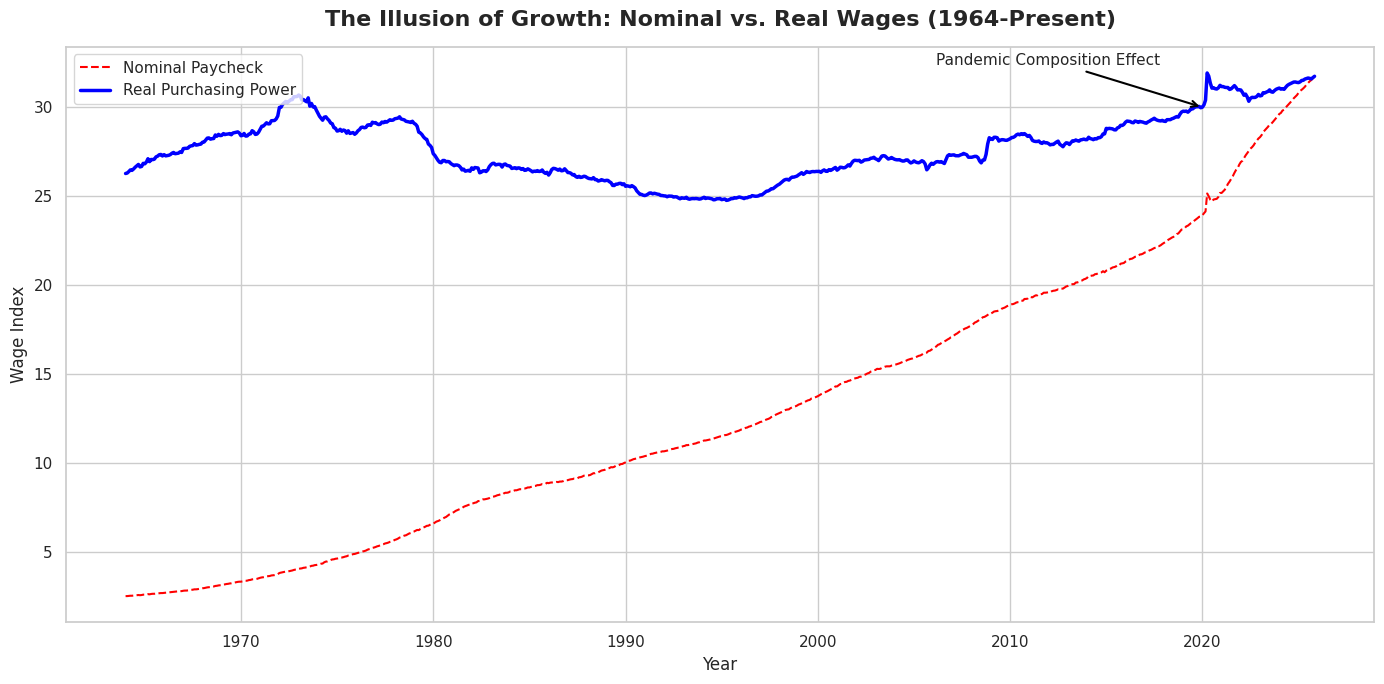

In [ ]:
# Set the whitegrid theme
sns.set_theme(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot Nominal Wage as dashed red line
ax.plot(df.index, df['Nominal_Wage'],
        color='red', linestyle='--', linewidth=1.5,
        label='Nominal Paycheck')

# Plot Real Wage as thick blue line
ax.plot(df.index, df['Real_Wage'],
        color='blue', linestyle='-', linewidth=2.5,
        label='Real Purchasing Power')

# Add title and labels
ax.set_title("The Illusion of Growth: Nominal vs. Real Wages (1964-Present)",
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Wage Index', fontsize=12)

# Add annotation arrow pointing to 2020 spike
# Find the 2020 Real Wage value for arrow placement
spike_date = df.loc['2020'].index[0]
spike_value = df.loc['2020', 'Real_Wage'].iloc[0] if hasattr(df.loc['2020', 'Real_Wage'], 'iloc') else df.loc['2020', 'Real_Wage']

ax.annotate('Pandemic Composition Effect',
            xy=(spike_date, spike_value),
            xytext=(spike_date - pd.DateOffset(years=8), spike_value * 1.08),
            fontsize=11,
            ha='center',
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# Add legend
ax.legend(loc='upper left', fontsize=11, frameon=True)

# Improve layout
plt.tight_layout()
plt.show()

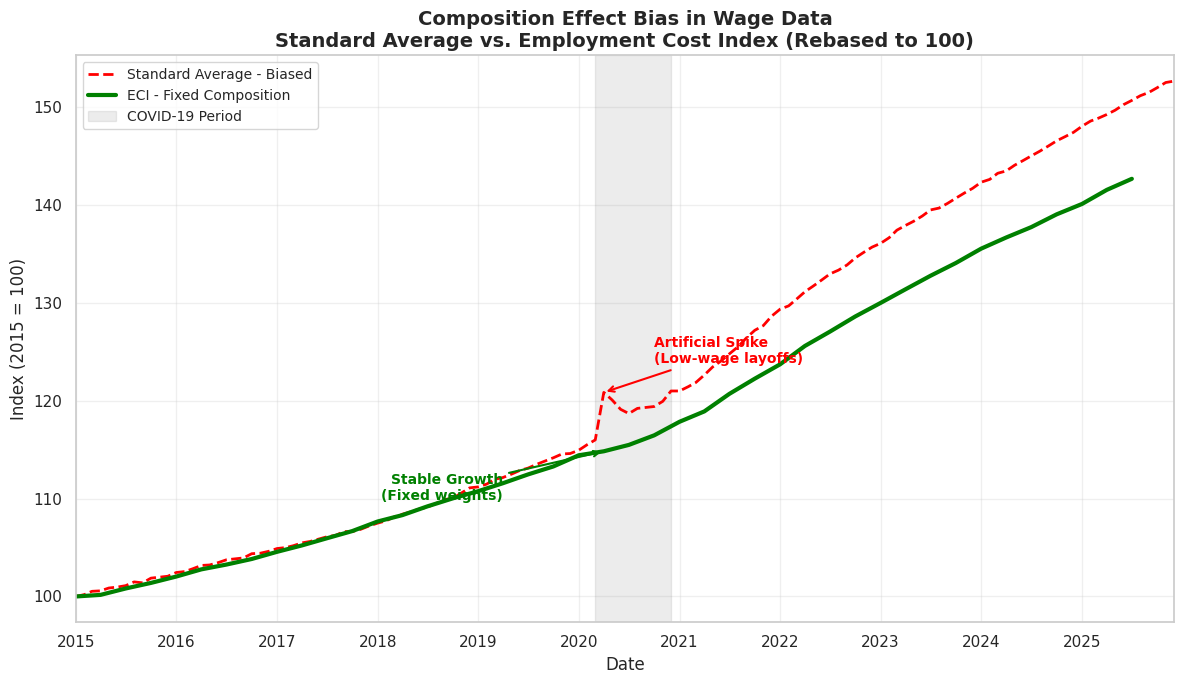


COMPOSITION EFFECT ANALYSIS

Total Growth (2015 to latest):
  Standard Average: 52.7%
  ECI (Fixed):      42.7%

2020 Peak Divergence:
  Standard peaked at: 120.9
  ECI at same time:   114.8
  Bias magnitude:     6.0 index points


In [ ]:
# =============================================================================
# Composition Effect Bias Correction: Standard Wages vs. ECI
# =============================================================================
# The Employment Cost Index (ECI) uses fixed occupation/industry weights,
# eliminating the composition bias that affects standard wage measures.

import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------------------------------------------------------
# 1. Fetch the Employment Cost Index (ECIWAG)
# -----------------------------------------------------------------------------
eci = fred.get_series('ECIWAG')

# -----------------------------------------------------------------------------
# 2. Filter both series from 2015 onwards
# -----------------------------------------------------------------------------
start_date = '2015-01-01'

wages_filtered = wages[wages.index >= start_date]
eci_filtered = eci[eci.index >= start_date]

# -----------------------------------------------------------------------------
# 3. Rebase both series to 100 (Index = Value / First Value * 100)
# -----------------------------------------------------------------------------
wages_rebased = (wages_filtered / wages_filtered.iloc[0]) * 100
eci_rebased = (eci_filtered / eci_filtered.iloc[0]) * 100

# -----------------------------------------------------------------------------
# 4. Plot comparison
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 7))

# Standard wages (biased) - Red Dashed
ax.plot(wages_rebased.index, wages_rebased,
        color='red', linestyle='--', linewidth=2,
        label='Standard Average - Biased')

# ECI (composition-adjusted) - Green Thick
ax.plot(eci_rebased.index, eci_rebased,
        color='green', linestyle='-', linewidth=3,
        label='ECI - Fixed Composition')

# -----------------------------------------------------------------------------
# 5. Annotate the 2020 divergence
# -----------------------------------------------------------------------------
# Find approximate 2020 peak in standard wages for annotation
covid_period = wages_rebased['2020-03':'2020-06']
if len(covid_period) > 0:
    spike_date = covid_period.idxmax()
    spike_value = covid_period.max()

    # Annotate the artificial spike
    ax.annotate('Artificial Spike\n(Low-wage layoffs)',
                xy=(spike_date, spike_value),
                xytext=(spike_date + pd.DateOffset(months=6), spike_value + 3),
                fontsize=10, color='red', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                ha='left')

# Find ECI value around the same time for stable growth annotation
eci_2020 = eci_rebased['2020-03':'2020-06']
if len(eci_2020) > 0:
    eci_date = eci_2020.index[len(eci_2020)//2]
    eci_value = eci_2020.iloc[len(eci_2020)//2]

    # Annotate stable growth
    ax.annotate('Stable Growth\n(Fixed weights)',
                xy=(eci_date, eci_value),
                xytext=(eci_date - pd.DateOffset(months=12), eci_value - 5),
                fontsize=10, color='green', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                ha='right')

# Add shaded region for COVID period
ax.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-12-01'),
           alpha=0.15, color='gray', label='COVID-19 Period')

# -----------------------------------------------------------------------------
# Formatting
# -----------------------------------------------------------------------------
ax.set_title('Composition Effect Bias in Wage Data\n'
             'Standard Average vs. Employment Cost Index (Rebased to 100)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Index (2015 = 100)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(wages_rebased.index.min(), wages_rebased.index.max())

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# Summary Statistics
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("COMPOSITION EFFECT ANALYSIS")
print("="*60)
print(f"\nTotal Growth (2015 to latest):")
print(f"  Standard Average: {wages_rebased.iloc[-1] - 100:.1f}%")
print(f"  ECI (Fixed):      {eci_rebased.iloc[-1] - 100:.1f}%")
print(f"\n2020 Peak Divergence:")
if len(covid_period) > 0:
    eci_at_spike = eci_rebased.loc[eci_rebased.index.asof(spike_date)]
    print(f"  Standard peaked at: {spike_value:.1f}")
    print(f"  ECI at same time:   {eci_at_spike:.1f}")
    print(f"  Bias magnitude:     {spike_value - eci_at_spike:.1f} index points")